# Simple RAG Applications System

Retrieval Augmented Generation (RAG) is a popular system is a technique that allows us to provide LLM with the necessary documents in a way that would enable us to better answer questions from the users. LangSmith eases the process of tracing any LLM application, so we do not require LangChain. 

So in order to begin, we must have a clear setup. In our case, we have already set up all of the environment, this is where we have enabled tracing, set up our Langsmith and LLM (gemini) API keys, and as well as named our project. 

To give a complete breakdown of what are the key important aspect we need to know about what the acronym actually stands for. 

* Retrieval : this will usually be a database of information or commonly reffered to as our knowledge base. When asking a question, the first step would be to retriev the most relevant pieve of information from the database. 


* Augmented : Taking the relevant information we have retrieved in the previous step we would augment our question with it. This is basically telling the AI "Here is what the user asked and here is some context that is likely to contain the answer.

* Generation : We send the augmented prompt to the LLM to generate a coherent answer based on the context provided. 

```
 +-------------------------+
 |      User's Question    |
 +-------------------------+
             |
             |
             V
 +-------------------------+
 |   1. RETRIEVAL          |
 |   (Search knowledge     |
 |   base for relevant     |
 |   documents)            |
 +-------------------------+
             |
             |
             V
 +-------------------------+
 |   2. AUGMENTATION       |
 |   (Combine question     |
 |   + retrieved docs      |
 |   into a new prompt)    |
 +-------------------------+
             |
             |
             V
 +-------------------------+
 |   3. GENERATION         |
 |   (Send augmented       |
 |   prompt to LLM like    |
 |   Gemini to get answer) |
 +-------------------------+
             |
             |
             V
 +-------------------------+
 |      Final Answer       |
 +-------------------------+
 ```

# Setup

In [1]:
import os 
import getpass

# Helper function to allow us to properly fetch the environment variables
def _get_config(api_name):
    if api_name in os.environ:
       print(f"{api_name} is set in environment variables.")
       return os.environ[api_name]
    else:
       print(f"{api_name} is not set in environment variables.")
       return getpass.getpass(f"Please enter your {api_name} API key: ")

In [ ]:
# Set up Google API key
os.environ["GOOGLE_API_KEY"] = _get_config("GOOGLE_API_KEY")

# Set up LangChain API Key
os.environ['LANGCHAIN_API_KEY'] = _get_config("LANGCHAIN_API_KEY")

# Configure Tracing and Project
os.environ['LANGCHAIN_TRACING_V2'] = _get_config("LANGCHAIN_TRACING_V2")
os.environ['LANGCHAIN_PROJECT'] = "simple-rag-application"


GOOGLE_API_KEY is set in environment variables.
LANGCHAIN_API_KEY is set in environment variables.
LANGCHAIN_TRACING_V2 is set in environment variables.
LANGCHAIN_PROJECT is set in environment variables.


Now that we have fetched our environment variables we will be creating a small rag application.

# Simple RAG Application Using LangSmith

So we will start by importing all of the necessary. And in this section we will look at what are the core things we would be using for this RAG application. 

Of course we would require `langchain` and `langchain-core` this will be the main toolkit that would provide us with the framework to connect all of the different pieces, mainly the retriever, the prompt and the model creating a single logical chain. 

Then we would need `langchain-google-genai` to act as a bridge between the LangChain framework and our Gemini LLM models. This will be handling the API calls, authentication and formatting needed to talk to Gemini. 


Then we would be using Facbeooks' AI Similarity Search (FAISS) an efficient library to find the most similar itmes in a large collection of vectors. 

For this simple RAG application here is the diagram that we would be implementing: 


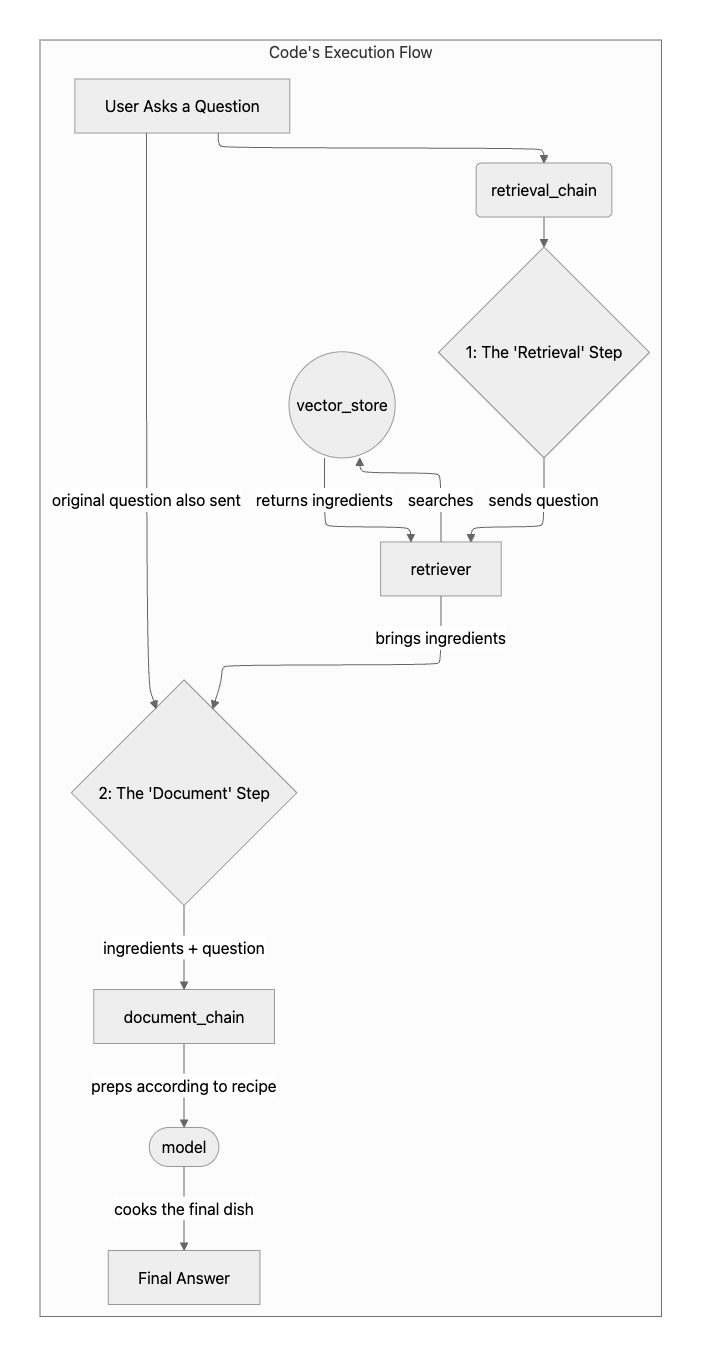
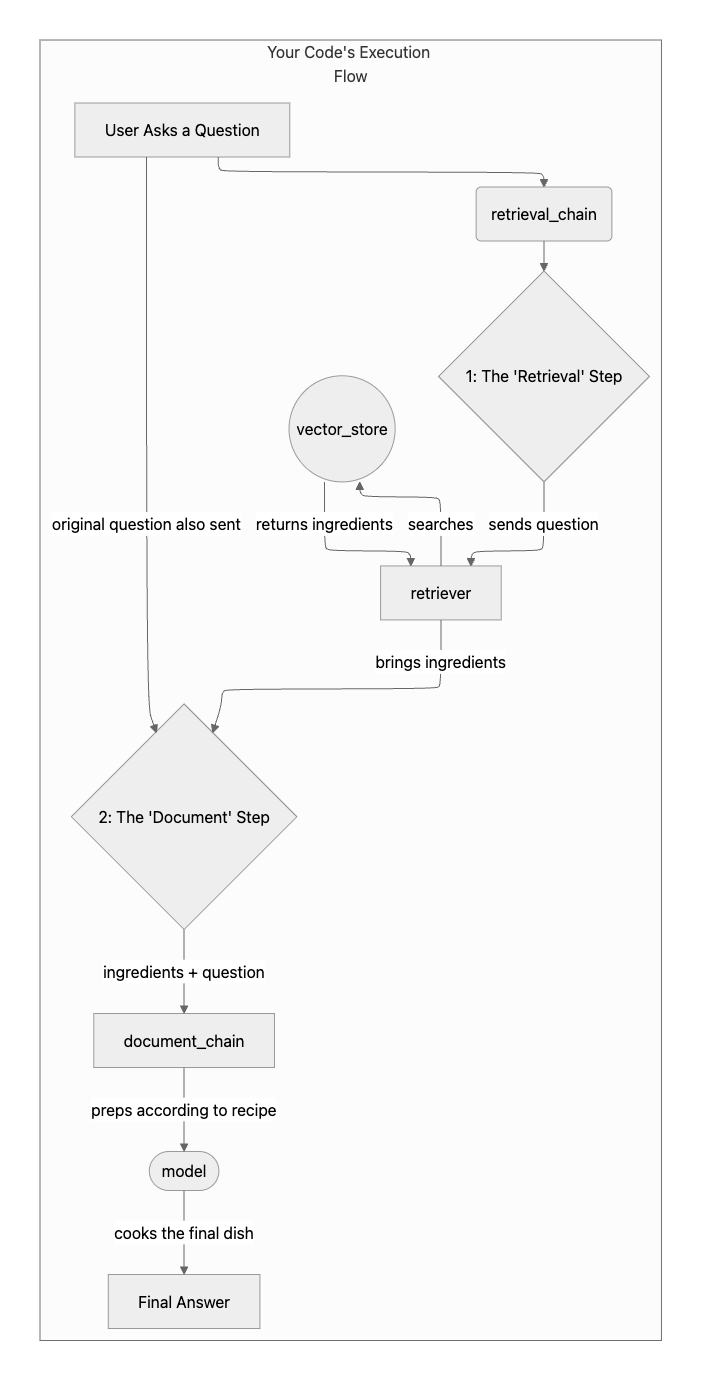

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

So now for all illutrative puposes we will be using a knowledge base that we would be actually creting ourslev and put it in a list. This is just for illustration, usually we would be PDFs or TXT or different formats of files contained in a database or a website but the end result is the same.

In [4]:
# We are assuming that each line is a self-contained document
documents = [
    "LangSmith is a platform for building production-grade LLM applications.",
    "It lets you debug, test, evaluate, and monitor chains and intelligent agents.",
    "LangSmith is built by the same team that created LangChain.",
    "To use LangSmith, you need to set the 'LANGCHAIN_TRACING_V2' environment variable to 'true'.",
]

print(f"Knowledge base is created with {len(documents)} document")

Knowledge base is created with 4 document


So now that we have a document (although simple), we need to embed the document. Embedding just transform the text-to-numbers. We will be using Google embeddings. After we have created our embedding we need to be able to store it in a searchable manner and that is why we will be using FAISS. So what is happening is that first we take the sentences from our document we have created and then we would pass it to be embedded, then we would use a highly optimized index of the coordinates. 

In [6]:
# Create our embedding 
embedding = GoogleGenerativeAIEmbeddings(model='models/embedding-001')


# Create a vector store that would allow us to search our documents
vector_store = FAISS.from_texts(documents, embedding)

Now we will be building, again we will be going back to the important components. The first thing we would need it a retriver, this would take the user's promot and use the same embedding as our documents to turn the promot or query into a vector and this would ask the FAISS index to find documents with the closest (or most relevant) coordinates. Then in order to maintain structure we will be using a prompt template, which basically tells the LLM, please give me the response in the followig format. 

In [15]:
# Retriever will fetch the relevant documents 
retriever = vector_store.as_retriever()


# Set up the LLM 
model = ChatGoogleGenerativeAI(model = "gemini-2.5-flash-lite", temperature = 0)


# Prompt Template to get a structured response
prompt = ChatPromptTemplate.from_template("""
Answer the following question based on the provided context:
                                          
<context>
{context}
</context> 
                                          
Question: {input}
""")

Now we are ready to create a small chain that would retrieve documents and also use the prompt from the user in order to actually give us a response. 

Let us think of it in terms of machines, we need one machine that would be able to respond to us. This machine would take the model and the prompt which is nothing the instruction manual or template that we had set. So the answer machine would be receiving the list of documents and the user's question and then it would give us the response. 

Then we need a master orchestrator that would be taking in the retriever, which takes the user's question and does to the database (or in our case it goes to the list of sentences for context) and the document chain is the machine that would be giving us the respons. 

```
  [User's Question]
          │
          ▼
┌───────────────────────────────┐
│ The "Full System" (retrieval_chain) │
│                                     │
│  1. Gives Question to `retriever`   │
│     to get a [List of Documents]    │
│                                     │
│              │                      │
│              ▼                      │
│                                     │
│  2. Feeds [List of Documents] AND   │
│     the original [User's Question]  │
│     into its internal...            │
│                                     │
│     ┌─────────────────────────┐     │
│     │ "Answering Machine"     │ ──► │  3. The final answer
│     │   (document_chain)      │     │     is produced.
│     └─────────────────────────┘     │
│                                     │
└───────────────────────────────┘
          │
          ▼
   [Final Answer]

   ```


In [ ]:
# This responsible for formatting them into the prompt
document_chain = create_stuff_documents_chain(model, prompt)

# This will be the main chain where it would take the question and send it to the retriever and get the documents and then would format them into the document_chain 
retrieval_chain = create_retrieval_chain(retriever, document_chain)

So now that we have set up our chain and our master orchestrator we can ask a question based on the simple question to our simple document. 

In [ ]:
question = "What is LangSmith?"

print(f"❓ Asking question: {question}")

# We need to invoke so that the entire chain is executed 
response = retrieval_chain.invoke({"input": question})

# The response is a dictionary containing the answer and the context
print("\n✅ Answer from RAG chain:")
print(response["answer"])

print("\n🔍 Context documents used:")
for doc in response["context"]:
    print(f"- {doc.page_content}")

❓ Asking question: What is LangSmith?

✅ Answer from RAG chain:
LangSmith is a platform for building production-grade LLM applications. It was built by the same team that created LangChain.

🔍 Context documents used:
- LangSmith is built by the same team that created LangChain.
- LangSmith is a platform for building production-grade LLM applications.
- To use LangSmith, you need to set the 'LANGCHAIN_TRACING_V2' environment variable to 'true'.
- It lets you debug, test, evaluate, and monitor chains and intelligent agents.


Now that we have seen how a simple RAG actually works and what is happening under the hood by tracing we will be using creating functions that implement this allowing us to break down the concepts. This would also allow us to better trace the function and add all of the appropriate metadata that is required for more about the veriosn of application that generate the run and the environment ins which the run was generated. This will be in the `testing/function_rag_application.ipynb` notebook. 